# Neural Network Genre Classifier

## Data Preprocessing

The files provided by the dataset take the *average* feature values over the song time interval. While the averages do work well for traditional data science algorithms, such as logistic regression and support-vector machine, neural networks can benefit from *more* data - like the actual time series values. Since this time series data is not provided directly in the Kaggle dataset, it is necessary to extract the features from the audio files to feed into the neural networks. 

### Train-Test Split the Songs

It is important to create a train-test split of the songs *before* splitting each song into three-second segments as to avoid mixing segments of the test songs into the actual training set.

In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = 'genres'

file_paths = []
labels = []

for genre in os.listdir(data_dir):
    genre_dir = os.path.join(data_dir, genre)
    if os.path.isdir(genre_dir):
        for file_name in os.listdir(genre_dir):
            file_paths.append(os.path.join(genre_dir, file_name))
            labels.append(genre)


train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, random_state=42, test_size=0.2, stratify=labels)

Split each of the songs in the train set into 3-second segments

In [9]:
import librosa

def split(file_path, segment_duration):
    y, sr = librosa.load(file_path)
    segment_samples = segment_duration * sr
    segments = []
    
    for start in range(0, len(y), segment_samples):
        end = start + segment_samples
        segment = y[start:end]
        
        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)), 'constant')
        
        segments.append(segment[:segment_samples])
    
    return segments, sr

train_segments = []
train_segment_labels = []

for file_path, label in zip(train_files, train_labels):
    segments, sr = split(file_path, 3)
    train_segments.extend(segments)
    train_segment_labels.extend([label] * len(segments))

Extract the relevant features from the songs using Librosa. Most of the same features as in the CSV were extracted, but some were excluded because they conflicted in dimensionality or yielded worse performance by including (e.g. no need to include all 20 mfcc's since only 13 suffice).

In [10]:
def extract_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)

    
    features = np.concatenate((mfccs, chroma, spectral_contrast, spectral_centroid, spectral_rolloff, zero_crossing_rate), axis=0)
    return features

train_features = []

for segment in train_segments:
    features = extract_features(segment, sr)
    train_features.append(features)

train_features = np.array(train_features)

c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


## Model Training

### LSTM

In [36]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape

train_features_lstm = train_features.transpose(0, 2, 1)

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_segment_labels)

X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(train_features_lstm, train_labels_encoded, test_size=0.2, stratify=train_labels_encoded)

lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(train_features_lstm.shape[1], train_features_lstm.shape[2])))
lstm_model.add(LSTM(75))
lstm_model.add(Dense(50))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(25))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(10, activation='softmax'))

lstm_model.summary()

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 130, 100)       │        54,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 75)             │        52,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,535 (439.59 KB)

 Trainable params: 112,535 (439.59 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm), epochs=100, batch_size=32)

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.1576 - loss: 2.2693 - val_accuracy: 0.3294 - val_loss: 1.9151
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.2808 - loss: 1.9920 - val_accuracy: 0.3663 - val_loss: 1.8210
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.3312 - loss: 1.8612 - val_accuracy: 0.3766 - val_loss: 1.7728
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.3235 - loss: 1.8467 - val_accuracy: 0.3652 - val_loss: 1.7762
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.3590 - loss: 1.7800 - val_accuracy: 0.3982 - val_loss: 1.6517
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.3475 - loss: 1.7716 - val_accuracy: 0.3948 - val_loss: 1.6029
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.3735 - loss: 1.7081 - val_accuracy: 0.4022 - val_loss: 1.6007
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.3924 - loss: 1

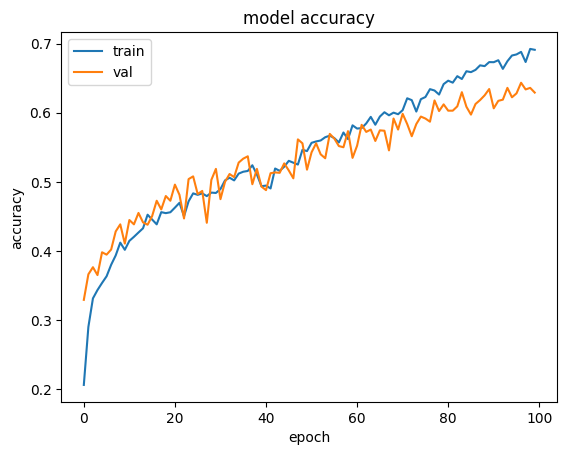

In [38]:
from matplotlib import pyplot as plt
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
lstm_model.save("LSTM.keras")

### CNN

In [40]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

train_features_cnn = train_features.reshape(train_features.shape[0], train_features.shape[1], train_features.shape[2], 1)

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_segment_labels)

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(train_features_cnn, train_labels_encoded, test_size=0.2, stratify=train_labels_encoded)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(train_features.shape[1], train_features.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
history = model.fit(X_train_cnn, y_train_cnn, epochs=100, batch_size=32, validation_data=(X_val_cnn, y_val_cnn))

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.1078 - loss: 3.3152 - val_accuracy: 0.2582 - val_loss: 2.1114
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.2276 - loss: 2.0922 - val_accuracy: 0.3094 - val_loss: 1.9183
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2816 - loss: 1.9060 - val_accuracy: 0.3316 - val_loss: 1.7933
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3099 - loss: 1.8050 - val_accuracy: 0.3652 - val_loss: 1.7416
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3504 - loss: 1.7186 - val_accuracy: 0.4187 - val_loss: 1.5610
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3543 - loss: 1.6873 - val_accuracy: 0.4096 - val_loss: 1.6775
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4102 - loss: 1.5747 - val_accuracy: 0.4664 - val_loss: 1.5439
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.4202 - loss: 1.5545 -

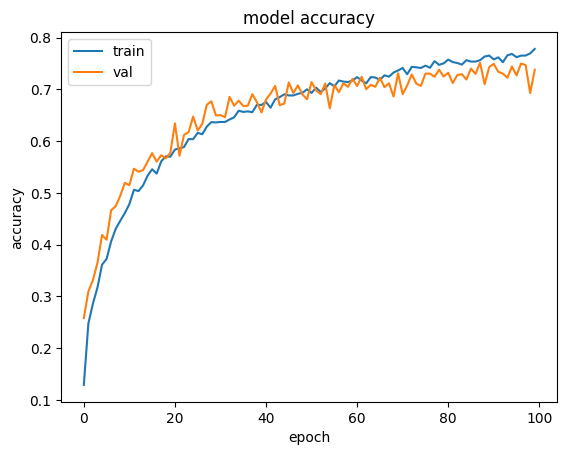

In [29]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
model.save("CNN.keras")

## Model Evaluation
In evaluating the test set, each song is evaluated by first splitting the song into 3-second segments, predicting the genre over each 3-second segment, and then classifying the entire song based on the *majority vote* of the segment labels. 

In [41]:
import numpy as np
from collections import Counter

test_segments = []
test_segment_labels = []
test_song_ids = []

for i, (file_path, label) in enumerate(zip(test_files, test_labels)):
    segments, sr = split(file_path, 3)
    test_segments.extend(segments)
    test_segment_labels.extend([label] * len(segments))
    test_song_ids.extend([i] * len(segments))

test_features = []

for segment in test_segments:
    features = extract_features(segment, sr)
    test_features.append(features)

test_features = np.array(test_features)



c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


## LSTM

In [49]:
from tensorflow.keras import models

model = models.load_model('LSTM.keras')
test_features_lstm = test_features.transpose(0, 2, 1)

segment_predictions = model.predict(test_features_lstm)
segment_pred_labels = np.argmax(segment_predictions, axis=1)

song_predictions = []
for song_id in set(test_song_ids):
    song_segment_pred_labels = [segment_pred_labels[i] for i in range(len(test_song_ids)) if test_song_ids[i] == song_id]
    majority_vote_label = Counter(song_segment_pred_labels).most_common(1)[0][0]
    song_predictions.append(majority_vote_label)

song_pred_labels = le.inverse_transform(song_predictions)

test_song_true_labels = le.transform(test_labels)
correct_predictions = sum(np.array(song_predictions) == test_song_true_labels)
accuracy = correct_predictions / len(test_song_true_labels)
print(f'Test Set Accuracy: {accuracy * 100:.2f}%')

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Test Set Accuracy: 70.50%


It appears from the Confusion Matrix that the weakest classification genres are Blues, Country, and Rock. The strongest classification genres are classical and pop.

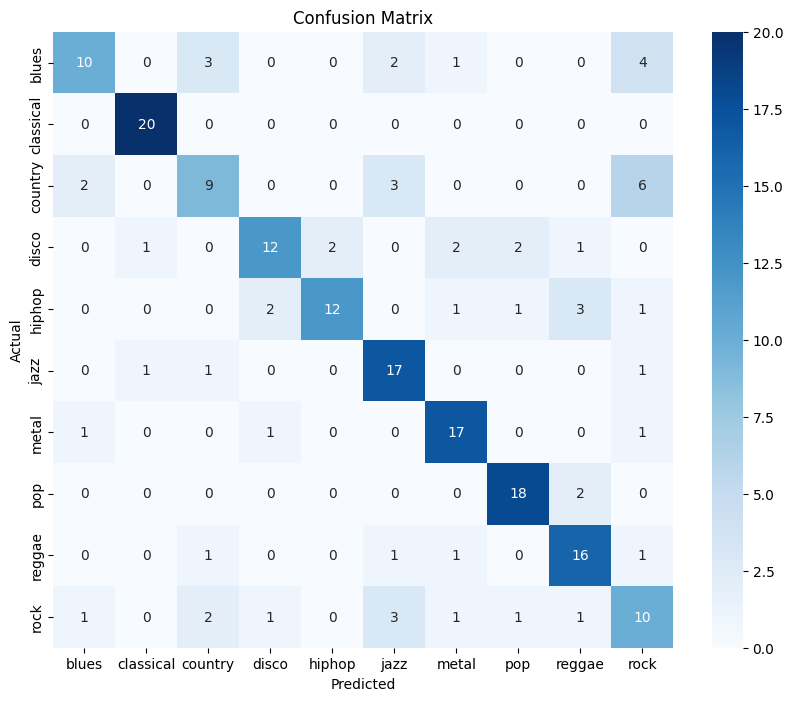

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = le.inverse_transform(song_predictions)
actual_labels = test_labels

cm = confusion_matrix(actual_labels, predicted_labels, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## CNN

The test accuracy was able to be better than the training and validation accuracy. This is because the evaluation is a sort of *ensembling* of the segment labels.

In [44]:
from tensorflow.keras import models

model = models.load_model('CNN.keras')
test_features_cnn = test_features.reshape(test_features.shape[0], test_features.shape[1], test_features.shape[2], 1)

segment_predictions = model.predict(test_features_cnn)
segment_pred_labels = np.argmax(segment_predictions, axis=1)

song_predictions = []
for song_id in set(test_song_ids):
    song_segment_pred_labels = [segment_pred_labels[i] for i in range(len(test_song_ids)) if test_song_ids[i] == song_id]
    majority_vote_label = Counter(song_segment_pred_labels).most_common(1)[0][0]
    song_predictions.append(majority_vote_label)

song_pred_labels = le.inverse_transform(song_predictions)

test_song_true_labels = le.transform(test_labels)
correct_predictions = sum(np.array(song_predictions) == test_song_true_labels)
accuracy = correct_predictions / len(test_song_true_labels)
print(f'Test Set Accuracy: {accuracy * 100:.2f}%')

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test Set Accuracy: 82.50%


It appears from the Confusion Matrix that the weakest classification genres are Disco and Reggae. For Disco, it seems as if there is confusion with Hip-Hop. For Reggae, it seems as if there is confusion with Hip-Hop and Country. These seem like reasonable genres to misclassify on, as they are fairly similar.

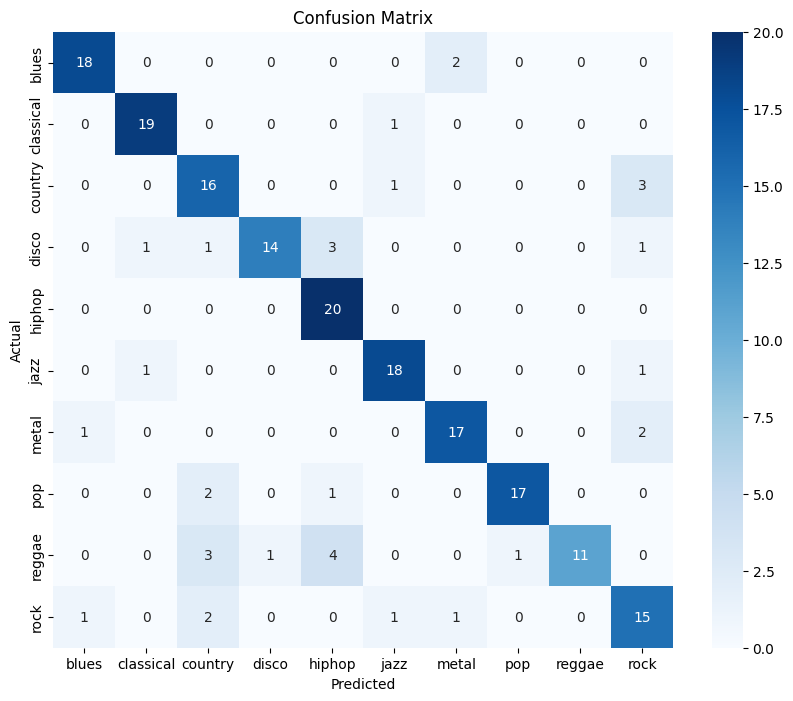

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_labels = le.inverse_transform(song_predictions)
actual_labels = test_labels

cm = confusion_matrix(actual_labels, predicted_labels, labels=le.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classify Test Songs

Since the CNN is the best model for classification, it can be tested on songs that are outside the dataset (e.g. modern-day songs)

In [51]:
def classify_song(file_path):
    segments, sr = split(file_path, 3)
    
    features = []
    for segment in segments:
        segment_features = extract_features(segment, sr)
        features.append(segment_features)
    
    features = np.array(features)
    features = features.reshape(features.shape[0], features.shape[1], features.shape[2], 1)
    
    segment_predictions = model.predict(features)
    segment_pred_labels = np.argmax(segment_predictions, axis=1)
    
    pred_counts = Counter(segment_pred_labels)
    
    total_segments = len(segment_pred_labels)
    pred_proportions = {le.inverse_transform([label])[0]: count / total_segments for label, count in pred_counts.items()}
    
    return pred_proportions

### Fortunate Son - Creedence Clearwater Revival (Rock)

In [40]:
proportions = classify_song('./Test_Songs/fortunate-son.wav')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


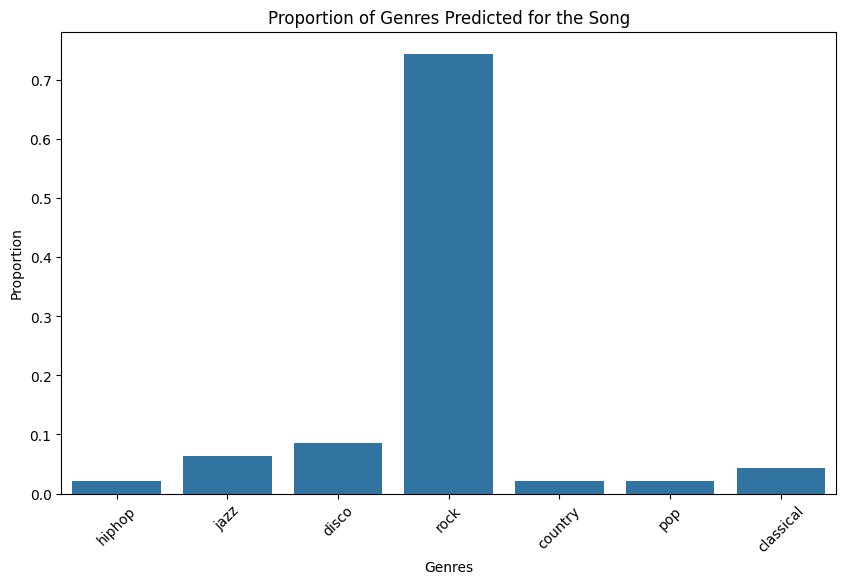

In [42]:
genres = list(proportions.keys())
proportions = list(proportions.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=genres, y=proportions)
plt.xlabel('Genres')
plt.ylabel('Proportion')
plt.title('Proportion of Genres Predicted for the Song')
plt.xticks(rotation=45)
plt.show()

### When You Sleep - My Bloody Valentine (Rock)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


([0, 1, 2, 3, 4],
 [Text(0, 0, 'rock'),
  Text(1, 0, 'jazz'),
  Text(2, 0, 'country'),
  Text(3, 0, 'metal'),
  Text(4, 0, 'classical')])

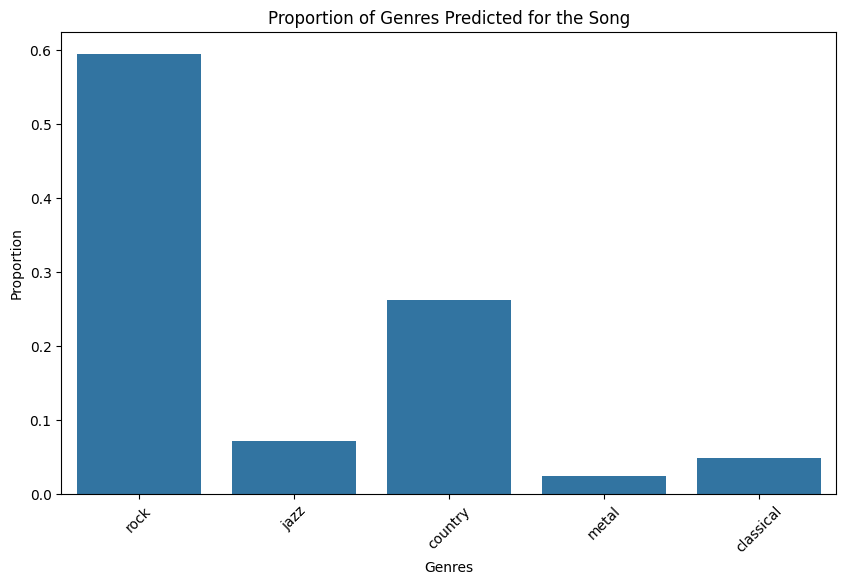

In [43]:
proportions = classify_song('./Test_Songs/when-you-sleep.wav')

genres = list(proportions.keys())
proportions = list(proportions.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=genres, y=proportions)
plt.xlabel('Genres')
plt.ylabel('Proportion')
plt.title('Proportion of Genres Predicted for the Song')
plt.xticks(rotation=45)

### Flashing Lights - Kanye West (Hip-Hop)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'rock'),
  Text(1, 0, 'classical'),
  Text(2, 0, 'pop'),
  Text(3, 0, 'country'),
  Text(4, 0, 'disco'),
  Text(5, 0, 'hiphop'),
  Text(6, 0, 'jazz'),
  Text(7, 0, 'blues')])

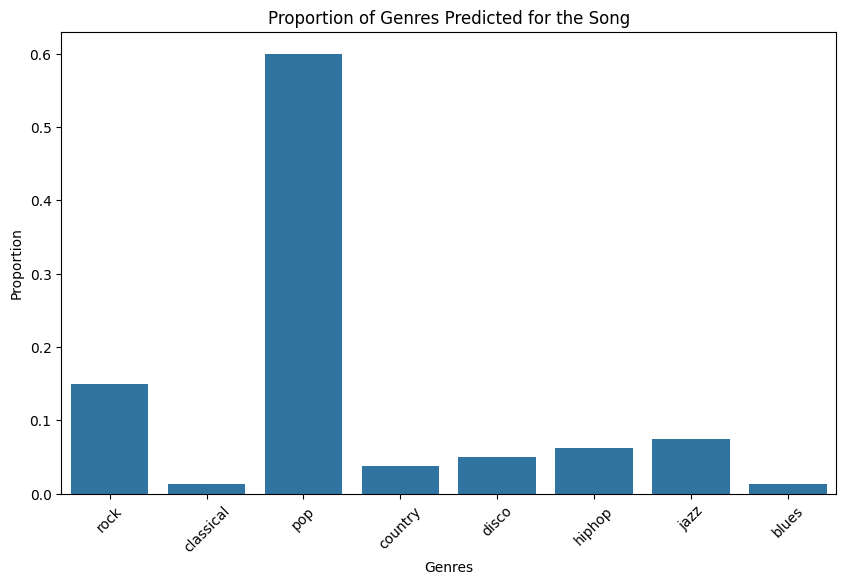

In [44]:
proportions = classify_song('./Test_Songs/flashing-lights.wav')

genres = list(proportions.keys())
proportions = list(proportions.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=genres, y=proportions)
plt.xlabel('Genres')
plt.ylabel('Proportion')
plt.title('Proportion of Genres Predicted for the Song')
plt.xticks(rotation=45)

It seems like the wrong prediction here has to do with the GTZAN dataset not being familiar with newer hip-hop. 

### The World is Yours - Nas (Hip-Hop)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'reggae'),
  Text(1, 0, 'rock'),
  Text(2, 0, 'country'),
  Text(3, 0, 'hiphop'),
  Text(4, 0, 'disco'),
  Text(5, 0, 'pop'),
  Text(6, 0, 'metal'),
  Text(7, 0, 'jazz'),
  Text(8, 0, 'classical')])

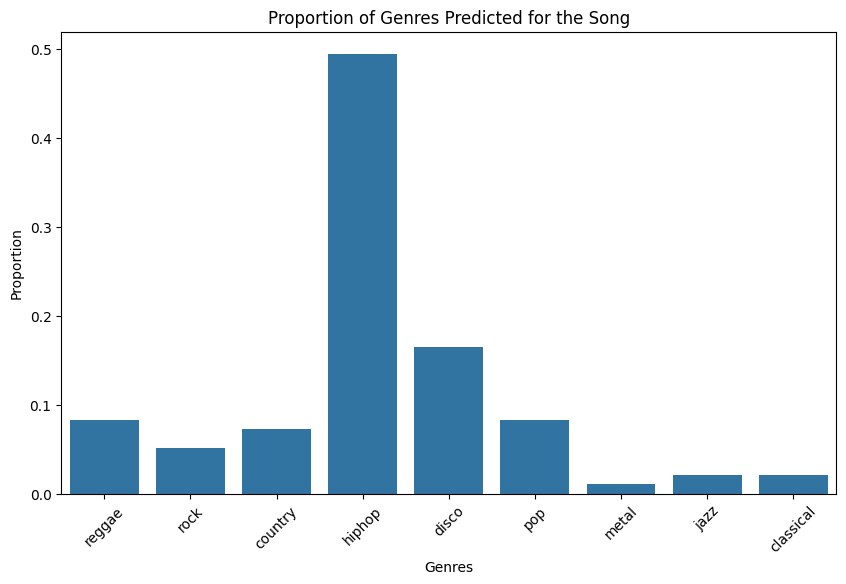

In [46]:
proportions = classify_song('./Test_Songs/the-world-is-yours.wav')

genres = list(proportions.keys())
proportions = list(proportions.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=genres, y=proportions)
plt.xlabel('Genres')
plt.ylabel('Proportion')
plt.title('Proportion of Genres Predicted for the Song')
plt.xticks(rotation=45)

### I Want You (She's So Heavy) - The Beatles (Rock)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'reggae'),
  Text(1, 0, 'rock'),
  Text(2, 0, 'country'),
  Text(3, 0, 'classical'),
  Text(4, 0, 'blues'),
  Text(5, 0, 'jazz'),
  Text(6, 0, 'hiphop'),
  Text(7, 0, 'disco'),
  Text(8, 0, 'metal')])

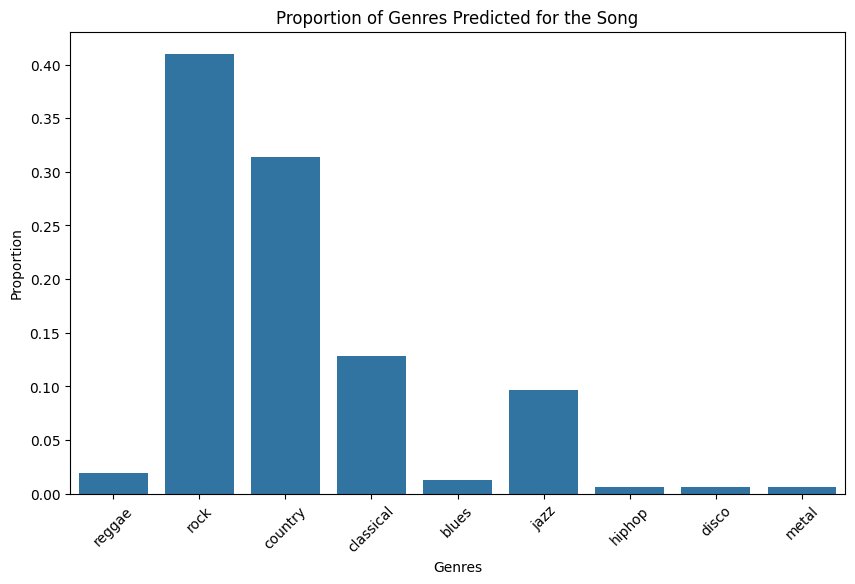

In [48]:
proportions = classify_song('./Test_Songs/i-want-you.wav')

genres = list(proportions.keys())
proportions = list(proportions.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=genres, y=proportions)
plt.xlabel('Genres')
plt.ylabel('Proportion')
plt.title('Proportion of Genres Predicted for the Song')
plt.xticks(rotation=45)